## Project Structure
```
2DIP_exercise/
│-- data/             # Contains images & videos
│   │-- input/        # 1 image and 1 video for each phase respectively
│   │-- output/       # All output images/videos must be stored here
│-- notebooks/        # Jupyter Notebooks for each phase
│   │-- part1.ipynb   # Image processing & feature extraction
│   │-- part2.ipynb   # Optical flow, object detection and tracking 
│-- README.md         # Project instructions
```

In [38]:
# imports
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [39]:
# define paths
base_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
inputs = os.path.join(base_path, 'data','input')
outputs = os.path.join(base_path, 'data','output')

## Supplementary Code for Visualization

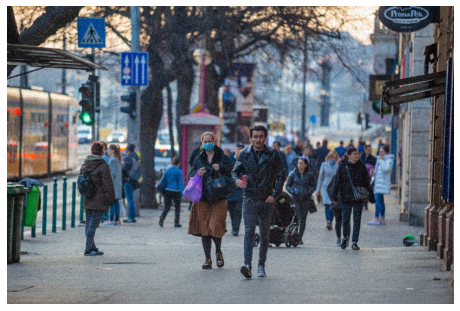

In [40]:
def display_images(image):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8, 6))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()
    
image = cv2.imread(os.path.join(inputs,"part1.jpg"))
display_images(image)

## Task 1 : Use image features to detect traffic signs in street images. **(7)**

a) Identify the type of noise and denoise the images. Use these denoised images for the next tasks. **(1)**

In [41]:
def denoise(input_path, output_path):
    """
    Reads an image from input_path, applies color denoising,
    writes the result to output_path, and returns the denoised image.
    """
    # load image
    img = cv2.imread(input_path)
    if img is None:
        raise FileNotFoundError(f"Could not read image at {input_path}")

    # apply Non-Local Means denoising
    # h=10 (luma strength), hColor=10 (chroma strength),
    # templateWindowSize=7, searchWindowSize=21
    denoised = cv2.fastNlMeansDenoisingColored(
        img, 
        None, 
        10,   # h
        10,   # hColor
        7,    # templateWindowSize
        21    # searchWindowSize
    )

    # save result
    if not cv2.imwrite(output_path, denoised):
        raise IOError(f"Could not write image to {output_path}")

    return denoised

Reading from: C:\Users\rsath\2D image\data\input\part1.jpg
Writing to:  C:\Users\rsath\2D image\data\output\denoised_part1.jpg
Input folder contains: ['part1.jpg', 'part2.mp4', 'template.png']


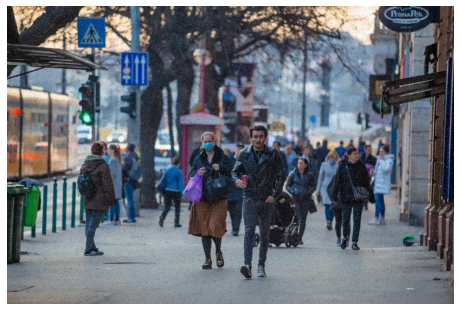

In [42]:
import os

# 1) figure out project root (one level above notebooks/)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# 2) point to your input/output folders under data/
inputs  = os.path.join(project_root, 'data', 'input')
outputs = os.path.join(project_root, 'data', 'output')

# 3) ensure the output folder actually exists
os.makedirs(outputs, exist_ok=True)

# 4) full paths to your images
image_path  = os.path.join(inputs,  'part1.jpg')           # <-- note: 'part1.jpg' not 'phase1.jpg'
output_path = os.path.join(outputs, 'denoised_part1.jpg')  # <-- just the filename here

# (Optional) sanity-check
print("Reading from:", image_path)
print("Writing to: ", output_path)
print("Input folder contains:", os.listdir(inputs))

# 5) now call your denoise + display
image = denoise(image_path, output_path)
display_images(image)

b) Detect regions corresponding to traffic signs. **(3)**

In [48]:

def segment_traffic_signs(input_path, output_path):
    img = cv2.imread(input_path)
    if img is None:
        raise FileNotFoundError(f"Could not read image at {input_path}")

    blur = cv2.GaussianBlur(img, (5,5), 0)
    hsv  = cv2.cvtColor(blur, cv2.COLOR_BGR2HSV)

    # red masks
    r1_lo, r1_hi = np.array([0,70,50]),   np.array([10,255,255])
    r2_lo, r2_hi = np.array([170,70,50]), np.array([180,255,255])
    b_lo,  b_hi  = np.array([100,150,50]),np.array([140,255,255])

    m1 = cv2.inRange(hsv, r1_lo, r1_hi)
    m2 = cv2.inRange(hsv, r2_lo, r2_hi)
    m3 = cv2.inRange(hsv, b_lo,  b_hi)
    mask = cv2.bitwise_or(m1, cv2.bitwise_or(m2, m3))

    # cleanup
    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, k, iterations=2)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN,  k, iterations=1)

    out = img.copy()
    cnts,_ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for c in cnts:
        if cv2.contourArea(c) > 500:
            x,y,w,h = cv2.boundingRect(c)
            cv2.rectangle(out, (x,y), (x+w,y+h), (0,255,0), 2)

    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    if not cv2.imwrite(output_path, out):
        raise IOError(f"Could not write image to {output_path}")
    return out


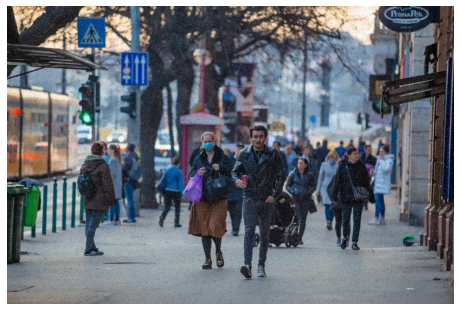

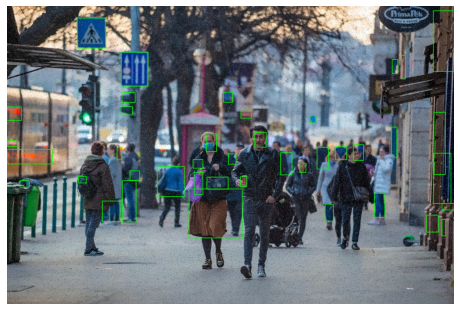

In [49]:
# 1) denoise
raw_in   = os.path.join(inputs,  'part1.jpg')
den_out  = os.path.join(outputs, 'denoised_part1.jpg')
denoised = denoise(raw_in, den_out)
display_images(denoised)

# 2) segment
seg_in   = den_out
seg_out  = os.path.join(outputs, 'color_segmented_part1.jpg')
seg_img  = segment_traffic_signs(seg_in, seg_out)
display_images(seg_img)

c) Refine detected region boundaries with appropriate methods. **(3)**

In [50]:

def refine_traffic_signs(input_path, output_path):
    """
    Reads the denoised image at input_path, finds red/yellow/green circles,
    groups them into vertical clusters that contain all three colors,
    draws a green bounding box around each true traffic-light, saves & returns.
    """
    import os
    import cv2
    import numpy as np

    # 1) load
    img = cv2.imread(input_path)
    if img is None:
        raise FileNotFoundError(f"Could not read image at {input_path}")

    # 2) HSV conversion
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # 3) color masks
    # red wraps around 0°, so two ranges
    red1_lo, red1_hi = np.array([0,70,50]),   np.array([10,255,255])
    red2_lo, red2_hi = np.array([170,70,50]), np.array([180,255,255])
    yellow_lo, yellow_hi = np.array([15,100,100]), np.array([35,255,255])
    green_lo,  green_hi  = np.array([40,70,70]),   np.array([90,255,255])

    mR = cv2.bitwise_or(
            cv2.inRange(hsv, red1_lo, red1_hi),
            cv2.inRange(hsv, red2_lo, red2_hi)
         )
    mY = cv2.inRange(hsv, yellow_lo, yellow_hi)
    mG = cv2.inRange(hsv, green_lo,  green_hi)

    # helper: detect circles in a mask via Hough
    def detect(mask):
        blur = cv2.GaussianBlur(mask, (9,9), 2)
        circles = cv2.HoughCircles(
            blur, cv2.HOUGH_GRADIENT, dp=1.2, minDist=20,
            param1=50, param2=15, minRadius=5, maxRadius=50
        )
        if circles is None:
            return []
        return [(int(x),int(y),int(r)) for x,y,r in circles[0]]

    reds    = detect(mR)
    yellows = detect(mY)
    greens  = detect(mG)

    # 4) collect all bulbs
    bulbs = []
    for x,y,r in reds:    bulbs.append({'x':x,'y':y,'r':r,'c':'R'})
    for x,y,r in yellows: bulbs.append({'x':x,'y':y,'r':r,'c':'Y'})
    for x,y,r in greens:  bulbs.append({'x':x,'y':y,'r':r,'c':'G'})

    # 5) cluster by horizontal proximity
    clusters = []
    for b in bulbs:
        placed = False
        for cl in clusters:
            # cluster if x within 40px of cluster mean
            xs = [bb['x'] for bb in cl]
            if abs(b['x'] - np.mean(xs)) < 40:
                cl.append(b)
                placed = True
                break
        if not placed:
            clusters.append([b])

    # 6) keep only clusters with all three colors and roughly vertical
    out = img.copy()
    for cl in clusters:
        cols = {b['c'] for b in cl}
        if cols != {'R','Y','G'}:
            continue

        # ensure they form a vertical stack: sort by y
        cl_sorted = sorted(cl, key=lambda b: b['y'])
        ys = [b['y'] for b in cl_sorted]
        # check roughly increasing y by at least radius each step
        if not (ys[1] - ys[0] > cl_sorted[0]['r']*0.5 and ys[2] - ys[1] > cl_sorted[1]['r']*0.5):
            continue

        # bounding box around all three bulbs
        xs = [b['x'] for b in cl_sorted]; rs = [b['r'] for b in cl_sorted]
        ys = [b['y'] for b in cl_sorted]
        x0 = min(x-r for x,r in zip(xs,rs))
        x1 = max(x+r for x,r in zip(xs,rs))
        y0 = min(y-r for y,r in zip(ys,rs))
        y1 = max(y+r for y,r in zip(ys,rs))

        pad = 8
        cv2.rectangle(out, (x0-pad,y0-pad), (x1+pad,y1+pad), (0,255,0), 2)

    # 7) save & return
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    if not cv2.imwrite(output_path, out):
        raise IOError(f"Could not write image to {output_path}")
    return out


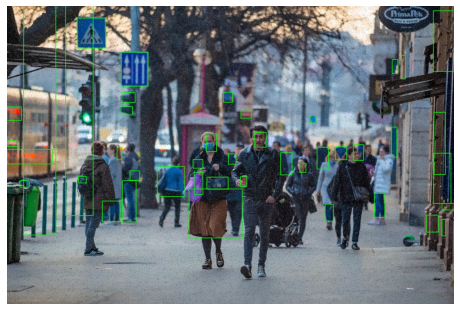

In [51]:
image_path  = os.path.join(outputs, 'color_segmented_part1.jpg')
output_path = os.path.join(outputs, 'refined_traffic_signs.jpg')

refined = refine_traffic_signs(image_path, output_path)
display_images(refined)


## Task 2 : Feature extraction and detection of pedestrians. **(8)**

a) Use an appropriate alogorithm to detect pedestrians. Draw bounding boxes around the detected pedestrians. **(3)**

In [ ]:
def detect_pedestrians(image_path, output_path):
    # TODO

In [ ]:
input_path = os.path.join(outputs, 'denoised_image.jpg')
output_path = os.path.join(outputs, 'pedestrians.jpg')

image = detect_pedestrians(input_path, output_path)
display_images(image)

b) Detect faces of pedestrian and draw a bounding box around detected faces. **(3)**

In [ ]:
def detect_faces(input_path, output_path):
    # TODO

In [ ]:
input_path = os.path.join(outputs, 'denoised_image.jpg')
output_path = os.path.join(outputs, 'faces.jpg')

image = detect_faces(input_path, output_path)
display_images(image)

c) Briefly discuss the methods used for the above tasks. **(2)**

In [ ]:
#TODO c):